### Data Preprocessing and Feature Selection

#### Handling Missing Data and Encoding

In [1]:
import numpy as np
np.random.seed(123) 

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Load the dataset
rta_dataset = pd.read_csv('RTA Dataset.csv')

# Create target variable for multi-vehicle involvement
rta_dataset["Multi_vehicle"] = (rta_dataset['Number_of_vehicles_involved'] > 1).astype(int)

# Fill missing values with mode (for categorical) or median (for numerical)
for col in rta_dataset.columns:
    if rta_dataset[col].dtype == 'object':
        rta_dataset[col] = rta_dataset[col].fillna(rta_dataset[col].mode()[0])
    else:
        rta_dataset[col] = rta_dataset[col].fillna(rta_dataset[col].median())

# Label Encoding for categorical features
from sklearn.preprocessing import LabelEncoder

encoded_features = []
label_encoders = {}
for col in rta_dataset.columns:
    if rta_dataset[col].dtype == 'object':
        le = LabelEncoder()
        rta_dataset[col] = le.fit_transform(rta_dataset[col])
        encoded_features.append(col)
        label_encoders[col] = le



#### Correlation analysis

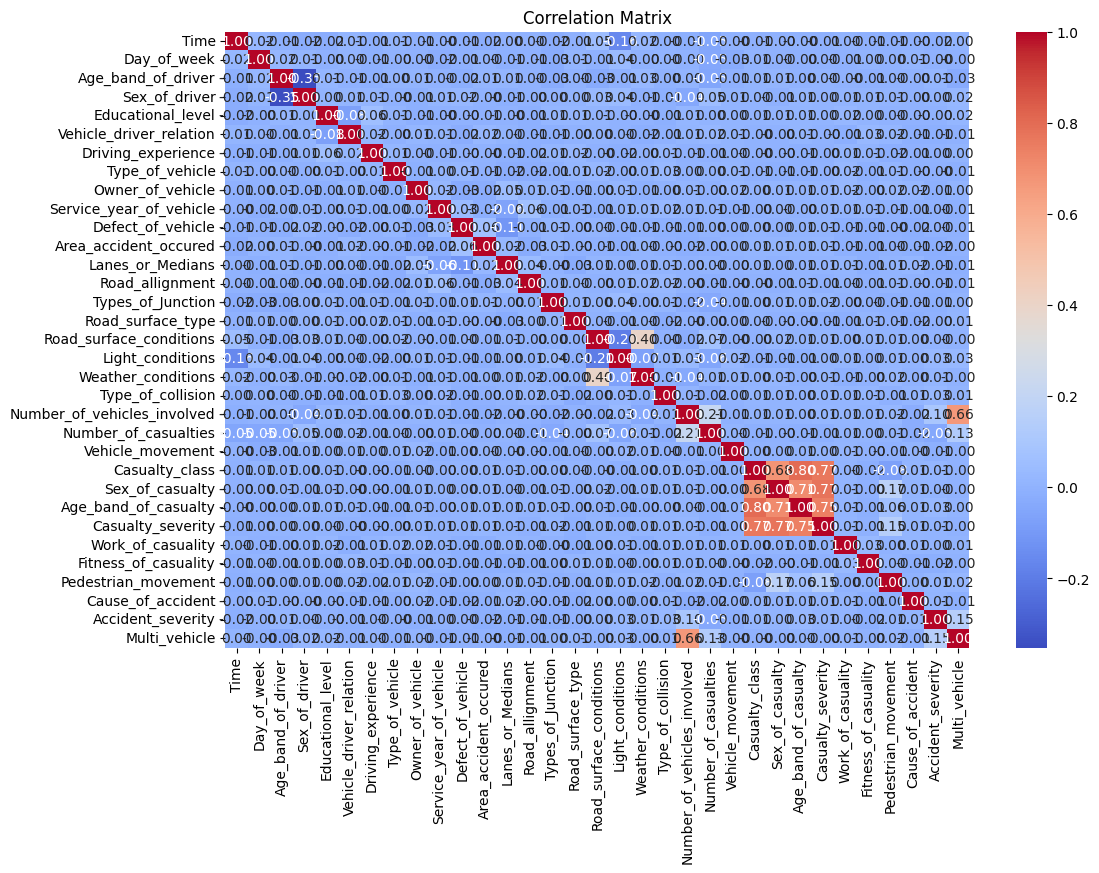

Correlation with Target (Multi_vehicle):
 Multi_vehicle                  1.000000
Number_of_vehicles_involved    0.664490
Accident_severity              0.147213
Number_of_casualties           0.127348
Light_conditions               0.025172
Sex_of_driver                  0.021084
Pedestrian_movement            0.020414
Educational_level              0.016484
Road_surface_type              0.008253
Type_of_collision              0.006480
Work_of_casuality              0.005498
Driving_experience             0.004401
Owner_of_vehicle               0.003810
Age_band_of_casualty           0.003789
Time                           0.003766
Types_of_Junction              0.003618
Casualty_severity             -0.000121
Road_surface_conditions       -0.000358
Vehicle_movement              -0.000463
Sex_of_casualty               -0.000758
Area_accident_occured         -0.000804
Casualty_class                -0.002630
Weather_conditions            -0.002662
Fitness_of_casuality          -0.00334

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
correlation_matrix = rta_dataset.corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Correlation with the target variable
correlation_with_target = correlation_matrix["Multi_vehicle"].sort_values(ascending=False)
print("Correlation with Target (Multi_vehicle):\n", correlation_with_target)


#### Statistical Tests for Categorical Features

In [4]:
from scipy.stats import chi2_contingency

# Perform Chi-Square test for categorical features
chi_square_results = {}
for col in encoded_features:
    contingency_table = pd.crosstab(rta_dataset[col], rta_dataset["Multi_vehicle"])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi_square_results[col] = p

# Print p-values
chi_square_results = pd.DataFrame.from_dict(chi_square_results, orient='index', columns=["p-value"])
chi_square_results = chi_square_results.sort_values(by="p-value")
print("Chi-Square Test Results:\n", chi_square_results)


Chi-Square Test Results:
                               p-value
Time                     6.920442e-99
Accident_severity        5.240132e-65
Types_of_Junction        3.505359e-17
Age_band_of_driver       1.642065e-06
Light_conditions         1.735933e-04
Sex_of_driver            1.332980e-02
Road_surface_type        1.540778e-02
Weather_conditions       1.610864e-02
Vehicle_movement         4.974136e-02
Road_surface_conditions  4.991111e-02
Day_of_week              1.103790e-01
Owner_of_vehicle         1.689374e-01
Fitness_of_casuality     1.762531e-01
Vehicle_driver_relation  2.439229e-01
Educational_level        2.627337e-01
Type_of_collision        2.835971e-01
Pedestrian_movement      3.841670e-01
Work_of_casuality        4.042566e-01
Type_of_vehicle          4.868320e-01
Road_allignment          5.151285e-01
Area_accident_occured    5.683869e-01
Driving_experience       5.768211e-01
Lanes_or_Medians         5.806521e-01
Defect_of_vehicle        6.497523e-01
Age_band_of_casualty    

#### Remove Low-Variance Features

In [5]:
X = rta_dataset.drop("Multi_vehicle", axis=1)
y = rta_dataset["Multi_vehicle"]

In [6]:
from sklearn.feature_selection import VarianceThreshold

# Remove low-variance features
selector = VarianceThreshold(threshold=0.01)  # Remove features with less than 1% variance
X_reduced = selector.fit_transform(X)
selected_features = X.columns[selector.get_support()]

print("Selected Features After Variance Threshold:\n", selected_features)

Selected Features After Variance Threshold:
 Index(['Time', 'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver',
       'Educational_level', 'Vehicle_driver_relation', 'Driving_experience',
       'Type_of_vehicle', 'Owner_of_vehicle', 'Service_year_of_vehicle',
       'Defect_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians',
       'Road_allignment', 'Types_of_Junction', 'Road_surface_type',
       'Road_surface_conditions', 'Light_conditions', 'Weather_conditions',
       'Type_of_collision', 'Number_of_vehicles_involved',
       'Number_of_casualties', 'Vehicle_movement', 'Casualty_class',
       'Sex_of_casualty', 'Age_band_of_casualty', 'Casualty_severity',
       'Work_of_casuality', 'Fitness_of_casuality', 'Pedestrian_movement',
       'Cause_of_accident', 'Accident_severity'],
      dtype='object')


Based on the above findings, Most relevant features for predicting the likelihood of multi-vehicle accidents:


In [7]:
features = [
    "Weather_conditions", "Road_surface_type", "Time", "Sex_of_driver",
    "Age_band_of_driver", "Driving_experience", "Vehicle_movement",
    "Light_conditions", "Number_of_casualties", "Types_of_Junction", "Accident_severity"
]

In [8]:
rta_dataset[features].dtypes

Weather_conditions      int64
Road_surface_type       int64
Time                    int64
Sex_of_driver           int64
Age_band_of_driver      int64
Driving_experience      int64
Vehicle_movement        int64
Light_conditions        int64
Number_of_casualties    int64
Types_of_Junction       int64
Accident_severity       int64
dtype: object

In [9]:
# Splitting features and target
X_mlp = rta_dataset[features]
y_mlp = rta_dataset["Multi_vehicle"]

# Standardizing numerical features
scaler = StandardScaler()
X_mlp_scaled = scaler.fit_transform(X_mlp)

# Splitting the dataset into training and testing sets
X_train_mlp, X_test_mlp, y_train_mlp, y_test_mlp = train_test_split(X_mlp_scaled, y_mlp, test_size=0.2, random_state=42)


### Model Training

In [10]:
from tensorflow.keras.layers import Input

# Building the MLP model
model_mlp = Sequential([
    Input(shape=(X_train_mlp.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compiling the model
model_mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the MLP model
history_mlp = model_mlp.fit(X_train_mlp, y_train_mlp, epochs=20, batch_size=32, validation_split=0.2, verbose=1)



Epoch 1/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8260 - loss: 0.4877 - val_accuracy: 0.8290 - val_loss: 0.4459
Epoch 2/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8379 - loss: 0.4350 - val_accuracy: 0.8285 - val_loss: 0.4413
Epoch 3/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8436 - loss: 0.4297 - val_accuracy: 0.8290 - val_loss: 0.4392
Epoch 4/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8429 - loss: 0.4211 - val_accuracy: 0.8290 - val_loss: 0.4381
Epoch 5/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8419 - loss: 0.4224 - val_accuracy: 0.8290 - val_loss: 0.4376
Epoch 6/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8306 - loss: 0.4355 - val_accuracy: 0.8290 - val_loss: 0.4390
Epoch 7/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8345 - loss: 0.4239 - val_accuracy: 0.8290 - val_loss: 0.4380
Epoch 8/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8462 - loss: 0.4125 - val_accuracy: 0.

### Model Evaluation

In [11]:
# Evaluating the model on the test set
y_pred_prob_mlp = model_mlp.predict(X_test_mlp)
y_pred_mlp = (y_pred_prob_mlp > 0.5).astype(int)

# Performance metrics
accuracy_mlp = accuracy_score(y_test_mlp, y_pred_mlp)
report_mlp = classification_report(y_test_mlp, y_pred_mlp)
roc_auc_mlp = roc_auc_score(y_test_mlp, y_pred_prob_mlp)

print("Accuracy:", accuracy_mlp)
print("Classification Report:\n", report_mlp)
print("ROC AUC Score:", roc_auc_mlp)


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step
Accuracy: 0.8319805194805194
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.00      0.01       413
           1       0.83      1.00      0.91      2051

    accuracy                           0.83      2464
   macro avg       0.62      0.50      0.46      2464
weighted avg       0.76      0.83      0.76      2464

ROC AUC Score: 0.6623415259549762


Class 0 (non-multi-vehicle accidents) and Class 1 (multi-vehicle accidents)

#### Identified Issues
Class Imbalance:
The dataset has a significant imbalance between classes 0 and 1. This imbalance skews the model's predictions heavily towards the majority class (1).
Poor Performance on Class 0:

The model fails to predict non-multi-vehicle accidents accurately, as indicated by the low precision, recall, and F1-score for class 0.

### Model Improvement

Before trying below ADASYN technique, I have experimented with SMOTHE sampling, hyperparameter tuning, adding class weights but there was no satisfactory improvement in results

### ADASYN (Adaptive Synthetic Sampling) with Focal loss function

In [12]:
from imblearn.over_sampling import ADASYN

# Apply ADASYN to balance the dataset
adasyn = ADASYN(random_state=42)
X_train_balanced, y_train_balanced = adasyn.fit_resample(X_train_mlp, y_train_mlp)

# Verify class distribution
print("Class distribution after ADASYN:", np.bincount(y_train_balanced))


Class distribution after ADASYN: [7675 8269]


In [13]:
import tensorflow.keras.backend as K

def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.sum(
            (1-alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed


In [14]:


# Update the MLP model with extra layers
model_mlp_deep = Sequential([
    Input(shape=(X_train_balanced.shape[1],)),  # Specify input shape
    Dense(256, activation='relu'),
    Dropout(0.4),  # Regularization
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model with focal loss
model_mlp_deep.compile(
    optimizer='adam',
    loss=focal_loss(alpha=0.25, gamma=2.0),  # Use focal loss
    metrics=['accuracy']
)

In [15]:
# Train the model
history_adasyn_deep = model_mlp_deep.fit(
    X_train_balanced, y_train_balanced,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


Epoch 1/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4580 - loss: 2.2689 - val_accuracy: 0.9288 - val_loss: 3.1883
Epoch 2/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4795 - loss: 2.1690 - val_accuracy: 0.9272 - val_loss: 2.9150
Epoch 3/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4997 - loss: 2.1276 - val_accuracy: 0.9533 - val_loss: 2.6699
Epoch 4/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4980 - loss: 2.1414 - val_accuracy: 0.9182 - val_loss: 2.9204
Epoch 5/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5005 - loss: 2.1141 - val_accuracy: 0.9627 - val_loss: 2.5743
Epoch 6/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5054 - loss: 2.0941 - val_accuracy: 0.9153 - val_loss: 2.8522
Epoch 7/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5253 - loss: 2.0756 - val_accuracy: 0.9069 - val_loss: 3.0568
Epoch 8/20
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5190 - loss: 2.0843 - val_accuracy: 0.

In [16]:
# Evaluate the model
y_pred_prob_adasyn_deep = model_mlp_deep.predict(X_test_mlp)
y_pred_adasyn_deep = (y_pred_prob_adasyn_deep > 0.5).astype(int)

# Calculate performance metrics
accuracy_adasyn_deep = accuracy_score(y_test_mlp, y_pred_adasyn_deep)
report_adasyn_deep = classification_report(y_test_mlp, y_pred_adasyn_deep)
roc_auc_adasyn_deep = roc_auc_score(y_test_mlp, y_pred_prob_adasyn_deep)

print("Accuracy:", accuracy_adasyn_deep)
print("Classification Report:\n", report_adasyn_deep)
print("ROC AUC Score:", roc_auc_adasyn_deep)


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
Accuracy: 0.4200487012987013
Classification Report:
               precision    recall  f1-score   support

           0       0.21      0.86      0.33       413
           1       0.92      0.33      0.49      2051

    accuracy                           0.42      2464
   macro avg       0.56      0.60      0.41      2464
weighted avg       0.80      0.42      0.46      2464

ROC AUC Score: 0.6740938985648057


In [17]:
def evaluate_adasyn_params(sampling_strategy, n_neighbors):
    # Apply ADASYN with the given parameters
    adasyn = ADASYN(sampling_strategy=sampling_strategy, n_neighbors=n_neighbors, random_state=42)
    X_train_balanced, y_train_balanced = adasyn.fit_resample(X_train_mlp, y_train_mlp)
    
    # Train the model
    history = model_mlp_deep.fit(
        X_train_balanced, y_train_balanced,
        epochs=20,
        batch_size=32,
        validation_split=0.2,
        verbose=0
    )
    
    # Evaluate the model
    y_pred_prob = model_mlp_deep.predict(X_test_mlp)
    y_pred = (y_pred_prob > 0.5).astype(int)
    report = classification_report(y_test_mlp, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test_mlp, y_pred_prob)
    
    return report, roc_auc


In [18]:
# Define the parameter grid
sampling_strategies = [0.5, 0.75, 'auto']
n_neighbors_values = [3, 5, 10]

# Iterate over parameter combinations
best_params = None
best_score = 0
results = []

for strategy in sampling_strategies:
    for neighbors in n_neighbors_values:
        print(f"Testing ADASYN with sampling_strategy={strategy}, n_neighbors={neighbors}")
        report, roc_auc = evaluate_adasyn_params(strategy, neighbors)
        results.append((strategy, neighbors, report['0']['f1-score'], roc_auc))
        
        # Track the best configuration
        if roc_auc > best_score:
            best_score = roc_auc
            best_params = (strategy, neighbors)

# Display the best parameters
print("Best ADASYN Parameters:", best_params)
print("Best ROC AUC Score:", best_score)


Testing ADASYN with sampling_strategy=0.5, n_neighbors=3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step
Testing ADASYN with sampling_strategy=0.5, n_neighbors=5
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
Testing ADASYN with sampling_strategy=0.5, n_neighbors=10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
Testing ADASYN with sampling_strategy=0.75, n_neighbors=3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
Testing ADASYN with sampling_strategy=0.75, n_neighbors=5
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
Testing ADASYN with sampling_strategy=0.75, n_neighbors=10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step
Testing ADASYN with sampling_strategy=auto, n_neighbors=3
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
Testing ADASYN with sampling_strategy=auto, n_neighbors=5
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
Testing ADASYN with sampling_strategy=auto, n_neighbors=10
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
Best ADASYN Parameters: (0.5, 3)
Best ROC AUC Score: 0.6858970348132312


In [19]:
# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=["Sampling Strategy", "Neighbors", "F1-Score (Class 0)", "ROC AUC"])
results_df = results_df.sort_values(by="ROC AUC", ascending=False)

# Display results
print(results_df)


  Sampling Strategy  Neighbors  F1-Score (Class 0)   ROC AUC
0               0.5          3            0.297810  0.685897
7              auto          5            0.359842  0.685695
2               0.5         10            0.337838  0.685073
3              0.75          3            0.355405  0.684449
1               0.5          5            0.336226  0.683962
5              0.75         10            0.358808  0.682850
8              auto         10            0.350939  0.678797
4              0.75          5            0.356688  0.678595
6              auto          3            0.340635  0.671489


In [20]:
# Re-train using the best ADASYN configuration
adasyn = ADASYN(sampling_strategy= 0.75, n_neighbors=5, random_state=42)
X_train_balanced, y_train_balanced = adasyn.fit_resample(X_train_mlp, y_train_mlp)

# Train the MLP model
history_adasyn_best = model_mlp_deep.fit(
    X_train_balanced, y_train_balanced,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Evaluate the model
y_pred_prob_adasyn_best = model_mlp_deep.predict(X_test_mlp)
y_pred_adasyn_best = (y_pred_prob_adasyn_best > 0.5).astype(int)

accuracy_adasyn_best = accuracy_score(y_test_mlp, y_pred_adasyn_best)
report_adasyn_best = classification_report(y_test_mlp, y_pred_adasyn_best)
roc_auc_adasyn_best = roc_auc_score(y_test_mlp, y_pred_prob_adasyn_best)

print("Accuracy:", accuracy_adasyn_best)
print("Classification Report:\n", report_adasyn_best)
print("ROC AUC Score:", roc_auc_adasyn_best)


Epoch 1/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6709 - loss: 1.5891 - val_accuracy: 0.8496 - val_loss: 2.7731
Epoch 2/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7059 - loss: 1.5312 - val_accuracy: 0.8851 - val_loss: 2.4708
Epoch 3/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6874 - loss: 1.5621 - val_accuracy: 0.8806 - val_loss: 2.4572
Epoch 4/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7123 - loss: 1.5215 - val_accuracy: 0.9160 - val_loss: 2.3616
Epoch 5/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6889 - loss: 1.5525 - val_accuracy: 0.8823 - val_loss: 2.5184
Epoch 6/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6905 - loss: 1.5478 - val_accuracy: 0.9095 - val_loss: 2.3488
Epoch 7/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6833 - loss: 1.5827 - val_accuracy: 0.9009 - val_loss: 2.3951
Epoch 8/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6876 - loss: 1.5619 - val_accuracy: 0.

Precision-Recall AUC: 0.9165154085018026


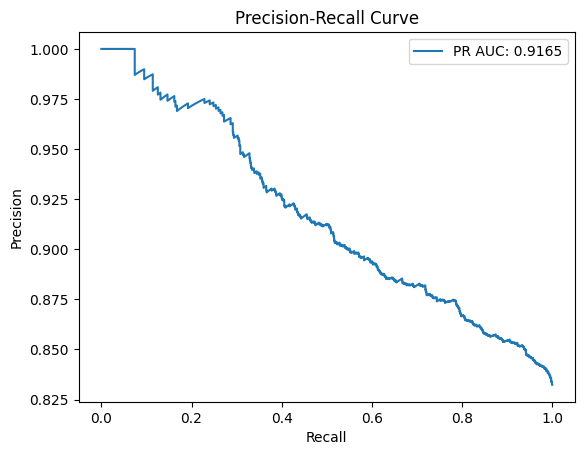

In [21]:
from sklearn.metrics import precision_recall_curve, auc

# Compute Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_mlp, y_pred_prob_adasyn_best)

# Calculate PR AUC
pr_auc = auc(recall, precision)

# Display PR AUC
print("Precision-Recall AUC:", pr_auc)

# Plot the Precision-Recall Curve
import matplotlib.pyplot as plt
plt.figure()
plt.plot(recall, precision, label=f"PR AUC: {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


PR AUC has a very high score, indicating that the model performs well in balancing precision and recall, particularly for the minority class (0).

In [22]:
# Update MLP model with varying dropout rates
model_mlp_dropout = Sequential([
    Input(shape=(X_train_balanced.shape[1],)),
    Dense(256, activation='relu'),
    Dropout(0.2),  # Lower dropout
    Dense(128, activation='relu'),
    Dropout(0.4),  # Higher dropout
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_mlp_dropout.compile(
    optimizer='adam',
    loss=focal_loss(alpha=0.25, gamma=2.0),  # Use focal loss
    metrics=['accuracy']
)

# Train the model
history_dropout = model_mlp_dropout.fit(
    X_train_balanced, y_train_balanced,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)



Epoch 1/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4989 - loss: 2.1938 - val_accuracy: 0.9326 - val_loss: 3.3931
Epoch 2/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4953 - loss: 2.0846 - val_accuracy: 0.7756 - val_loss: 3.8411
Epoch 3/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5168 - loss: 2.0468 - val_accuracy: 0.8923 - val_loss: 3.4933
Epoch 4/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5007 - loss: 2.0403 - val_accuracy: 0.8283 - val_loss: 3.5317
Epoch 5/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5304 - loss: 2.0349 - val_accuracy: 0.9092 - val_loss: 3.1380
Epoch 6/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5140 - loss: 2.0183 - val_accuracy: 0.8703 - val_loss: 3.5739
Epoch 7/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5272 - loss: 2.0001 - val_accuracy: 0.8802 - val_loss: 3.3899
Epoch 8/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5282 - loss: 1.9717 - val_accuracy: 0.

In [23]:
# Evaluate the model
y_pred_prob_dropout = model_mlp_dropout.predict(X_test_mlp)
y_pred_dropout = (y_pred_prob_dropout > 0.5).astype(int)

accuracy_dropout = accuracy_score(y_test_mlp, y_pred_dropout)
report_dropout = classification_report(y_test_mlp, y_pred_dropout)

# Compute Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_mlp, y_pred_prob_dropout)

# Sort recall and precision to ensure monotonicity
sorted_indices = np.argsort(recall)
recall_sorted = recall[sorted_indices]
precision_sorted = precision[sorted_indices]

# Calculate PR AUC
pr_auc_dropout = auc(recall_sorted, precision_sorted)
print("Accuracy:", accuracy_dropout)
print("Classification Report:\n", report_dropout)
print("Precision-Recall AUC:", pr_auc_dropout)


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
Accuracy: 0.5012175324675324
Classification Report:
               precision    recall  f1-score   support

           0       0.22      0.78      0.35       413
           1       0.91      0.44      0.60      2051

    accuracy                           0.50      2464
   macro avg       0.57      0.61      0.47      2464
weighted avg       0.80      0.50      0.55      2464

Precision-Recall AUC: 0.9060670465158476


### Adding Early Stopping to prevent overfitting

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitor validation loss
    patience=5,               # Number of epochs with no improvement to wait
    restore_best_weights=True # Restore the weights of the best epoch
)


In [25]:
history_early_stopping = model_mlp_dropout.fit(
    X_train_balanced, y_train_balanced,
    epochs=100,                # Set a high maximum number of epochs
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping], # Add early stopping
    verbose=1
)


Epoch 1/100
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5888 - loss: 1.8470 - val_accuracy: 0.9074 - val_loss: 3.0873
Epoch 2/100
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5692 - loss: 1.8632 - val_accuracy: 0.8476 - val_loss: 3.1184
Epoch 3/100
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5890 - loss: 1.8248 - val_accuracy: 0.9281 - val_loss: 2.9683
Epoch 4/100
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5761 - loss: 1.8021 - val_accuracy: 0.8365 - val_loss: 3.2811
Epoch 5/100
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5862 - loss: 1.8330 - val_accuracy: 0.9236 - val_loss: 2.9075
Epoch 6/100
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5918 - loss: 1.8093 - val_accuracy: 0.9085 - val_loss: 2.9580
Epoch 7/100
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5881 - loss: 1.8132 - val_accuracy: 0.9133 - val_loss: 2.9696
Epoch 8/100
364/364 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5879 - loss: 1.8125 - val_accu

In [26]:
# Predictions
y_pred_prob_early = model_mlp_dropout.predict(X_test_mlp)
y_pred_early = (y_pred_prob_early > 0.39).astype(int)

# Performance metrics
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve, auc

# Calculate metrics
accuracy_early = accuracy_score(y_test_mlp, y_pred_early)
report_early = classification_report(y_test_mlp, y_pred_early)
precision, recall, thresholds = precision_recall_curve(y_test_mlp, y_pred_prob_early)
pr_auc_early = auc(recall, precision)

# Print metrics
print("Accuracy (Early Stopping):", accuracy_early)
print("Classification Report (Early Stopping):\n", report_early)
print("Precision-Recall AUC (Early Stopping):", pr_auc_early)


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
Accuracy (Early Stopping): 0.8218344155844156
Classification Report (Early Stopping):
               precision    recall  f1-score   support

           0       0.37      0.09      0.14       413
           1       0.84      0.97      0.90      2051

    accuracy                           0.82      2464
   macro avg       0.60      0.53      0.52      2464
weighted avg       0.76      0.82      0.77      2464

Precision-Recall AUC (Early Stopping): 0.9096203360359219


#### 7. Adjust classification thresholds

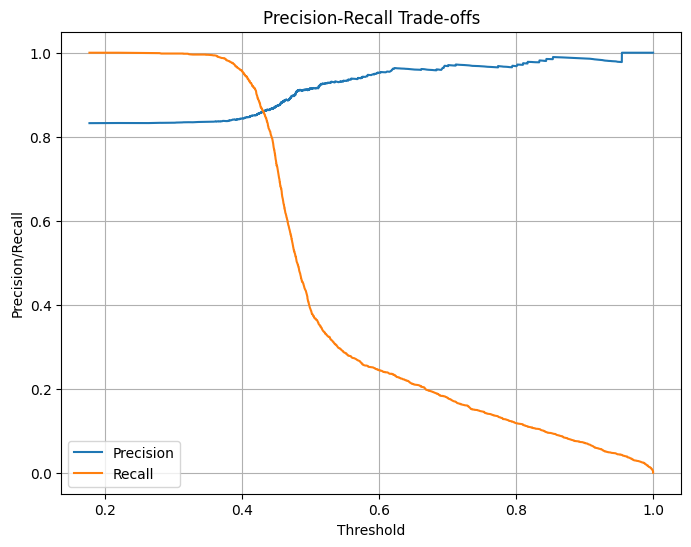

In [27]:
# Plot Precision-Recall trade-offs
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Precision/Recall")
plt.title("Precision-Recall Trade-offs")
plt.legend()
plt.grid()
plt.show()

In [28]:
# Define new thresholds to evaluate
thresholds_to_test = [0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49]

for threshold in thresholds_to_test:
    print(f"Evaluating Threshold: {threshold}")
    
    # Apply threshold
    y_pred_new = (y_pred_prob_early > threshold).astype(int)
    
    # Evaluate performance
    accuracy_new = accuracy_score(y_test_mlp, y_pred_new)
    report_new = classification_report(y_test_mlp, y_pred_new)
    precision, recall, _ = precision_recall_curve(y_test_mlp, y_pred_prob_early)
    pr_auc_new = auc(recall, precision)
    
    print(f"Accuracy: {accuracy_new}")
    print(f"Classification Report:\n{report_new}")
    print(f"PR AUC: {pr_auc_new}")
    print("-" * 50)


Evaluating Threshold: 0.4
Accuracy: 0.8161525974025974
Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.12      0.18       413
           1       0.84      0.96      0.90      2051

    accuracy                           0.82      2464
   macro avg       0.60      0.54      0.54      2464
weighted avg       0.76      0.82      0.78      2464

PR AUC: 0.9096203360359219
--------------------------------------------------
Evaluating Threshold: 0.41
Accuracy: 0.8043831168831169
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.16      0.21       413
           1       0.85      0.93      0.89      2051

    accuracy                           0.80      2464
   macro avg       0.59      0.55      0.55      2464
weighted avg       0.76      0.80      0.78      2464

PR AUC: 0.9096203360359219
--------------------------------------------------
Evaluating Threshold: 0.42
Accura

Threshold 0.44 is the better choice based on the RTA dataset because:
It improves recall for multi-vehicle accidents (0), which is critical in this context.
It provides a balanced accuracy of above 70%.
While precision drops slightly, it’s acceptable given the importance of identifying as many potential multi-vehicle accidents as possible.
The improved F1-score and balanced performance make it more suitable for real-world accident prediction systems.

In [29]:
# Apply final threshold
y_pred_final = (y_pred_prob_early > 0.44).astype(int)

# Evaluate performance
accuracy_final = accuracy_score(y_test_mlp, y_pred_final)
report_final = classification_report(y_test_mlp, y_pred_final)
precision, recall, _ = precision_recall_curve(y_test_mlp, y_pred_prob_early)

print(f"Accuracy: {accuracy_final}")
print(f"Classification Report:\n{report_final}")
print(f"PR AUC: {pr_auc_new}")


Accuracy: 0.7406655844155844
Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.36      0.32       413
           1       0.86      0.82      0.84      2051

    accuracy                           0.74      2464
   macro avg       0.57      0.59      0.58      2464
weighted avg       0.77      0.74      0.75      2464

PR AUC: 0.9096203360359219


## Ensemble Modelling

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from scikeras.wrappers import KerasClassifier

# Wrap MLP model for Sklearn
def build_mlp_model():
    model = Sequential([
        Input(shape=(X_train_balanced.shape[1],)),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [31]:
# Wrap MLP model with Early Stopping
mlp_wrapper = KerasClassifier(model=build_mlp_model, epochs=50, batch_size=32, verbose=0)

# Add early stopping during fit
mlp_wrapper.fit(
    X_train_balanced,
    y_train_balanced,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Base models
logistic = LogisticRegression(random_state=42, max_iter=1000)
random_forest = RandomForestClassifier(random_state=42, n_estimators=100)
svc = SVC(probability=True, random_state=42)


In [32]:
from sklearn.ensemble import VotingClassifier

# Define ensemble with Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('mlp', mlp_wrapper),
        ('logistic', logistic),
        ('random_forest', random_forest),
        ('svc', svc)
    ],
    voting='soft'
)

# Fit Voting Classifier (MLP uses early stopping internally)
voting_clf.fit(X_train_balanced, y_train_balanced)

# Evaluate Voting Classifier
y_pred_voting = voting_clf.predict(X_test_mlp)
print("Accuracy (Voting Classifier):", accuracy_score(y_test_mlp, y_pred_voting))
print("Classification Report (Voting Classifier):\n", classification_report(y_test_mlp, y_pred_voting))


Accuracy (Voting Classifier): 0.7751623376623377
Classification Report (Voting Classifier):
               precision    recall  f1-score   support

           0       0.34      0.35      0.34       413
           1       0.87      0.86      0.86      2051

    accuracy                           0.78      2464
   macro avg       0.60      0.60      0.60      2464
weighted avg       0.78      0.78      0.78      2464



In [33]:
from sklearn.ensemble import StackingClassifier

# Define Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=[
        ('logistic', logistic),
        ('random_forest', random_forest),
        ('svc', svc)
    ],
    final_estimator=LogisticRegression()  # Meta-learner
)

# Fit Stacking Classifier (MLP uses early stopping internally)
stacking_clf.fit(X_train_balanced, y_train_balanced)

# Evaluate Stacking Classifier
y_pred_stacking = stacking_clf.predict(X_test_mlp)
print("Accuracy (Stacking Classifier):", accuracy_score(y_test_mlp, y_pred_stacking))
print("Classification Report (Stacking Classifier):\n", classification_report(y_test_mlp, y_pred_stacking))



Accuracy (Stacking Classifier): 0.788961038961039
Classification Report (Stacking Classifier):
               precision    recall  f1-score   support

           0       0.35      0.29      0.32       413
           1       0.86      0.89      0.88      2051

    accuracy                           0.79      2464
   macro avg       0.60      0.59      0.60      2464
weighted avg       0.78      0.79      0.78      2464



In [34]:
results_en = {
    "Model": ["Base MLP", "Voting Classifier", "Stacking Classifier"],
    "Accuracy": [
        accuracy_score(y_test_mlp, y_pred_final),  # Base MLP (ADASYN + Early Stopping)
        accuracy_score(y_test_mlp, y_pred_voting),
        accuracy_score(y_test_mlp, y_pred_stacking)
    ],
    "F1-Score (Class 0)": [
        classification_report(y_test_mlp, y_pred_final, output_dict=True)['0']['f1-score'],
        classification_report(y_test_mlp, y_pred_voting, output_dict=True)['0']['f1-score'],
        classification_report(y_test_mlp, y_pred_stacking, output_dict=True)['0']['f1-score']
    ]
}


en_df = pd.DataFrame(results_en)
print(en_df)

                 Model  Accuracy  F1-Score (Class 0)
0             Base MLP  0.740666            0.318036
1    Voting Classifier  0.775162            0.342043
2  Stacking Classifier  0.788961            0.315789
